
# Wind 1 — Price Prediction (ERCOT)

This notebook loads **Wind 1 (ERCOT)** data using the repo modules and performs the **price prediction step**:
1. Load per-asset CSV data (history + forwards) from `configs/project.yaml`  
2. Build **hourly hub forward** for 2026–2030 (Peak/Off-Peak monthly → hourly shaping)  
3. Compute **basis stats** and **simulate** hourly **hub/node** RT/DA prices for ERCOT  
4. Save outputs to `results/` for downstream use


In [1]:

import yaml
import pandas as pd
import numpy as np
from pathlib import Path
from src.data.loader import load_data
from src.features.calendar import make_calendar_index
from src.models.shape import hub_hourly_shape, basis_stats
from src.models.price import shape_monthly_to_hourly, simulate_prices

CONFIG_PATH = "configs/project.yaml"
ASSET_NAME = "Wind_A"     # Wind 1
MARKET = "ERCOT"
SCENARIOS = 500
SEED = 42

cfg = yaml.safe_load(open(CONFIG_PATH, "r"))
start_year = cfg["start_year"]
end_year = cfg["end_year"]


In [2]:

hist_all, fwd_all = load_data(cfg)
hist = hist_all[hist_all["market"] == MARKET].copy()

display(hist.head(3))
display(fwd_all[fwd_all["market"] == MARKET].head(3))

print("Hist rows (ERCOT):", len(hist))
print("Fwd rows (all markets):", len(fwd_all))


/Users/mohammad/Documents/rec_hedge_pricer/src/data/loader.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/Users/mohammad/Documents/rec_hedge_pricer/src/data/loader.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/Users/mohammad/Documents/rec_hedge_pricer/src/data/loader.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/Users/mohammad/Documents/rec_hedge_pricer/src/data/loader.py:93: UserWarning: Could not infer format, so each element will 

,date,he,peak_flag,gen_mwh,rt_node,rt_hub,da_node,da_hub,asset,market
0,2022-01-01,1,OP,36.8,0.74,56.43,5.20,30.17,Wind_A,ERCOT
1,2022-01-01,2,OP,17.0,3.78,29.24,1.54,22.08,Wind_A,ERCOT
2,2022-01-01,3,OP,14.6,4.00,22.15,1.83,19.97,Wind_A,ERCOT


,month,market,peak,offpeak
0,2026-01-01,ERCOT,66.41,61.71
1,2026-02-01,ERCOT,66.38,59.84
2,2026-03-01,ERCOT,47.90,37.77


Hist rows (ERCOT): 26304
Fwd rows (all markets): 180


In [3]:

cal = make_calendar_index(start_year, end_year)
cal.head()


,ts,date,he,month,weekday
0,2026-01-01 00:00:00,2026-01-01,1,2026-01-01,3
1,2026-01-01 01:00:00,2026-01-01,2,2026-01-01,3
2,2026-01-01 02:00:00,2026-01-01,3,2026-01-01,3
3,2026-01-01 03:00:00,2026-01-01,4,2026-01-01,3
4,2026-01-01 04:00:00,2026-01-01,5,2026-01-01,3


In [4]:

shape_tbl = hub_hourly_shape(hist)
shape_tbl.head()


,market,month,hour,shape
0,ERCOT,2022-01-01,1,1.027560
1,ERCOT,2022-01-01,2,0.815155
2,ERCOT,2022-01-01,3,0.816499
3,ERCOT,2022-01-01,4,0.837539
4,ERCOT,2022-01-01,5,0.861922


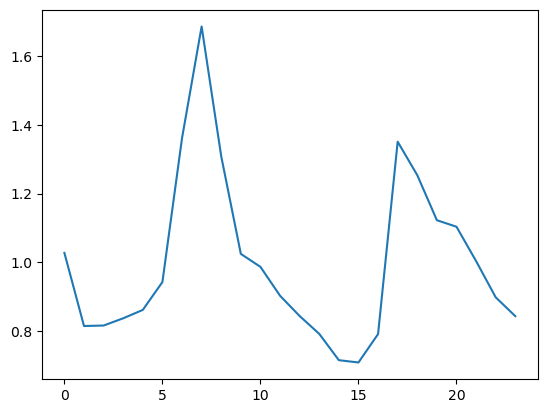

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.array(shape_tbl['shape'].head(24)))

In [5]:

hh_all = shape_monthly_to_hourly(fwd_all, shape_tbl, cal)
hh = hh_all[hh_all["market"] == MARKET].copy().sort_values("ts").reset_index(drop=True)
print("Hourly hub forward rows (ERCOT):", len(hh))
hh.head()


TypeError: unsupported Type RangeIndex

In [ ]:

bs_rt = basis_stats(hist, price_col_hub="rt_hub", price_col_node="rt_node")
sims_all = simulate_prices(hh, bs_rt, n_scenarios=SCENARIOS, seed=SEED)
sims = sims_all[sims_all["market"] == MARKET].copy().sort_values(["s","ts"]).reset_index(drop=True)
sims.head()


In [ ]:

summary = sims.groupby("ts")[["hub_rt","node_rt","hub_da","node_da"]].agg(["mean","median","min","max"])
summary.columns = ["_".join(col) for col in summary.columns]
summary = summary.reset_index()
summary.head()


In [ ]:

import matplotlib.pyplot as plt

first_period = summary.iloc[:24*30]
plt.figure()
plt.plot(first_period["ts"], first_period["hub_rt_mean"], label="Hub RT (mean)")
plt.plot(first_period["ts"], first_period["node_rt_mean"], label="Node RT (mean)")
plt.legend()
plt.title("ERCOT Hourly Price (Scenario Mean) — First 30 Days")
plt.xlabel("Time")
plt.ylabel("$/MWh")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

hh.to_csv(results_dir / "wind1_hourly_hub_forward.csv", index=False)
sims.to_parquet(results_dir / "wind1_sim_prices.parquet", index=False)

print("Saved:")
print(" - results/wind1_hourly_hub_forward.csv")
print(" - results/wind1_sim_prices.parquet")


In [ ]:

import pandas as pd
pd.read_csv("results/wind1_hourly_hub_forward.csv").head(3)
